# **Hypothesis testing**

## Objectives

* Perform hypothesis testing set out in the business requirements.

## Inputs

* Cleaned data saved in https://github.com/8osco/academic_performance_analysis/blob/main/data/inputs/cleaned/edu_data_cleaned.csv
* Initial analyses performed in [1_data_etl.ipynb](https://github.com/8osco/academic_performance_analysis/blob/main/jupyter_notebooks/1_data_etl.ipynb)
* Exploratory data analysis performed in [2_exploratory_analysis](https://github.com/8osco/academic_performance_analysis/blob/main/jupyter_notebooks/2_exploratory_analysis.ipynb)



## Outputs

* Hypothesis test results.

# 1 Import packages


Import relevant packages required for data analysis and visualisation.

In [1]:
# Import NumPy, Pandas, Matplotlib, Seaborn and Plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 2 Data extract and familiarisation

Read in the cleaned csv file and familiarise with the file structure at a high level, through use of various dataframe methods:

In [2]:
# Load the dataset and display the first few rows
df = pd.read_csv('../data/inputs/cleaned/edu_data_cleaned.csv')
df.head()

,gender,nationality,place_of_birth,education_stage,grade,classroom_id,subject,semester,parent_involved,raised_hands,resource_visits,announcements_viewed,discussion_participation,parent_answered_survey,parent_school_satisfaction,absence_category,pass_fail_status
0,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,15,16,2,20,yes,good,low,pass
1,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,20,20,3,25,yes,good,low,pass
2,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,10,7,0,30,no,bad,high,fail
3,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,30,25,5,35,no,bad,high,fail
4,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,40,50,12,50,no,bad,high,pass


In [3]:
# Display the shape of the DataFrame
df.shape

(478, 17)

In [4]:
# Display the column data types and check for null or missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   gender                      478 non-null    object
 1   nationality                 478 non-null    object
 2   place_of_birth              478 non-null    object
 3   education_stage             478 non-null    object
 4   grade                       478 non-null    object
 5   classroom_id                478 non-null    object
 6   subject                     478 non-null    object
 7   semester                    478 non-null    object
 8   parent_involved             478 non-null    object
 9   raised_hands                478 non-null    int64 
 10  resource_visits             478 non-null    int64 
 11  announcements_viewed        478 non-null    int64 
 12  discussion_participation    478 non-null    int64 
 13  parent_answered_survey      478 non-null    object

# 3 Hypothesis Testing

We will proceed with the testing of the 4 hypotheses in this section.

1. Students who raised their hands more often were more likely to pass.

First, we should decide whether we use a parametric or non-parametric statistical test.

One of the criteria for parametric tests to be used is that the data is normally distributed, which is to be tested below.

We start by plotting the distribution of hand-raising behaviour separately for the pass and fail groups, using Seaborn histograms.  We also have QQ plots alongside to help visualise how close the data is to a normal distribution, using Pingouin (as learnt from the Code Institute course).

In [5]:
# Install Pingouin
#%pip install pingouin

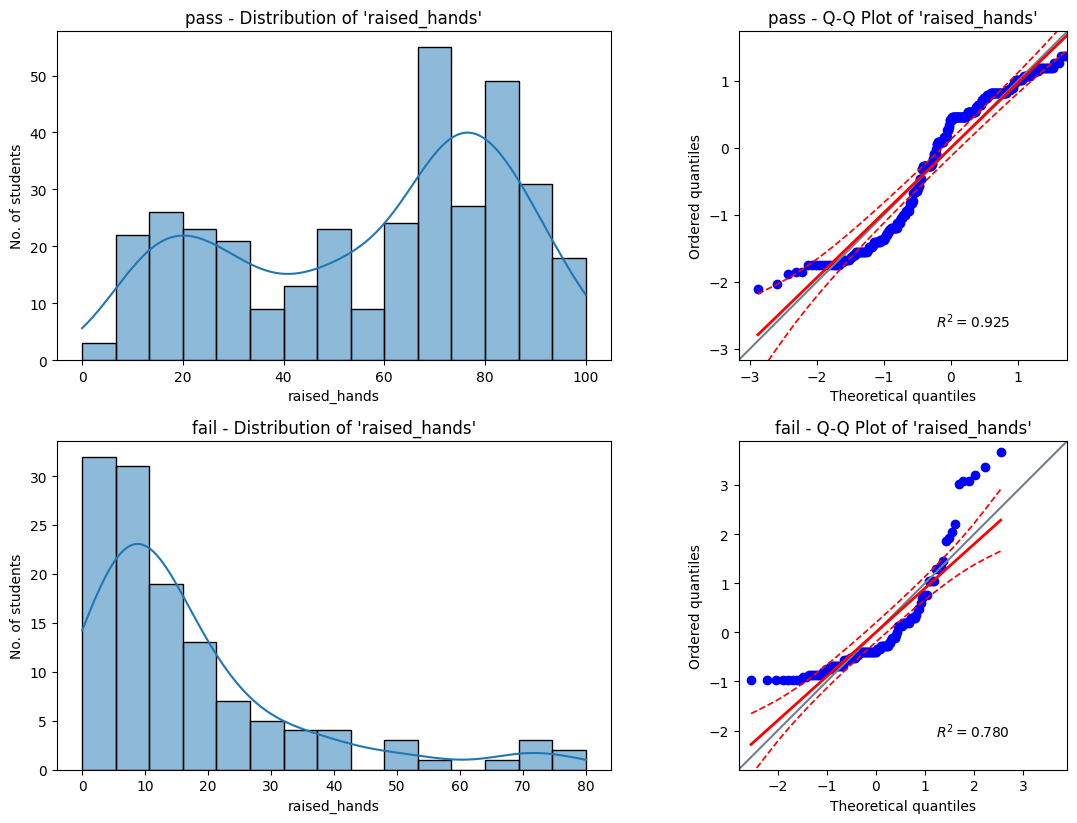

In [13]:
import pingouin as pg

# Setup for plots
plt.figure(figsize=(12, 12))  # set figure size

for i, c in enumerate(['pass', 'fail']):   # iterate over 'pass' and 'fail' categories
    data = df[df['pass_fail_status'] == c]['raised_hands'] # filter data for current category
    
    # Histogram
    plt.subplot(3, 2, 2*i+1) # create subplot for histogram
    sns.histplot(data, kde=True, bins=15)  # include KDE for better visualization and set number of bins
    plt.title(f"{c} - Distribution of 'raised_hands'") # set title
    plt.xlabel("raised_hands") # set x-axis label
    plt.ylabel("No. of students") # set y-axis label
    
    # Q-Q Plot
    plt.subplot(3, 2, 2*i+2) # create subplot for Q-Q plot
    pg.qqplot(data, dist='norm')  # compare to normal distribution
    plt.title(f"{c} - Q-Q Plot of 'raised_hands'") # set title

plt.tight_layout() # adjust layout to prevent overlap
plt.show()

The histograms suggest that they are not normally distributed.  On the other hand, R-square's in the QQ plots are very high, reflecting close alignment between the quantiles of the data and the quantiles of a theoretical normal distribution.  It is noted however that R-square in a Q-Q plot is not a test of normality.  

To proceed with the normality test, we run the Shapiro-Wilk test below, using Pingouin.

In [ ]:
results = pg.normality(data=df, dv='raised_hands', group='pass_fail_status', method='shapiro') # Shapiro-Wilk test for normality (with significance level set to 0.05 as default)

print(results)

                         W          pval  normal
pass_fail_status                                
pass              0.921672  1.274802e-12   False
fail              0.780451  2.149761e-12   False


As shown in the last column of the output above, the data is not normally distributed, and so we will use a non-parametric test for the hypothesis testing.  Here we use Kruskal-Wallis test.

In [ ]:
# Kruskal-Wallis test - null hypothesis: the distributions of 'raised_hands' are the same across 'pass' and 'fail' groups
# significant level is set to 0.05 by default in Pingouin
result = pg.kruskal(data=df, dv='raised_hands', between='pass_fail_status')

print(result)

                   Source  ddof1           H         p-unc
Kruskal  pass_fail_status      1  168.045052  1.977702e-38


Since p-value (1.977702e-38) is lower than our significant level (assumed to be 0.05), there is enough evidence to reject the null hypothesis and conclude that the distributions of 'raised_hands' are different between the 'pass' and 'fail' groups.  This is consistent with our observations from the histogram plots above.

Whilst the Kruskal-Wallis test tells us that the distributions of the two groups are different, it does not say whether the pass group has higher number of raised hands.

We can compute mean and variance to help with this.

In [ ]:
for c in ['pass', 'fail']: # iterate over 'pass' and 'fail' categories
    group_data = df[df['pass_fail_status'] == c]['raised_hands'] # filter data for current category
    mean_val = group_data.mean() # calculate mean
    var_val = group_data.var() # calculate variance
    
    print(f"{c.upper()} group:")
    print(f"  Mean      = {mean_val:.2f}")
    print(f"  Variance  = {var_val:.2f}\n")

PASS group:
  Mean      = 57.53
  Variance  = 744.98

FAIL group:
  Mean      = 16.84
  Variance  = 299.17



Here, we can see that pass group has a higher mean of raised hands (57.53) compared to the fail group (16.84). 
The variance is also much higher in the pass group, compared to the fail group.  This suggests that students who passed tend to raise their hands more frequently on average, but also over a wider range.

2. Students who visited more resources were more likely to pass.

We will assess the hypothesis through use of similar plots:

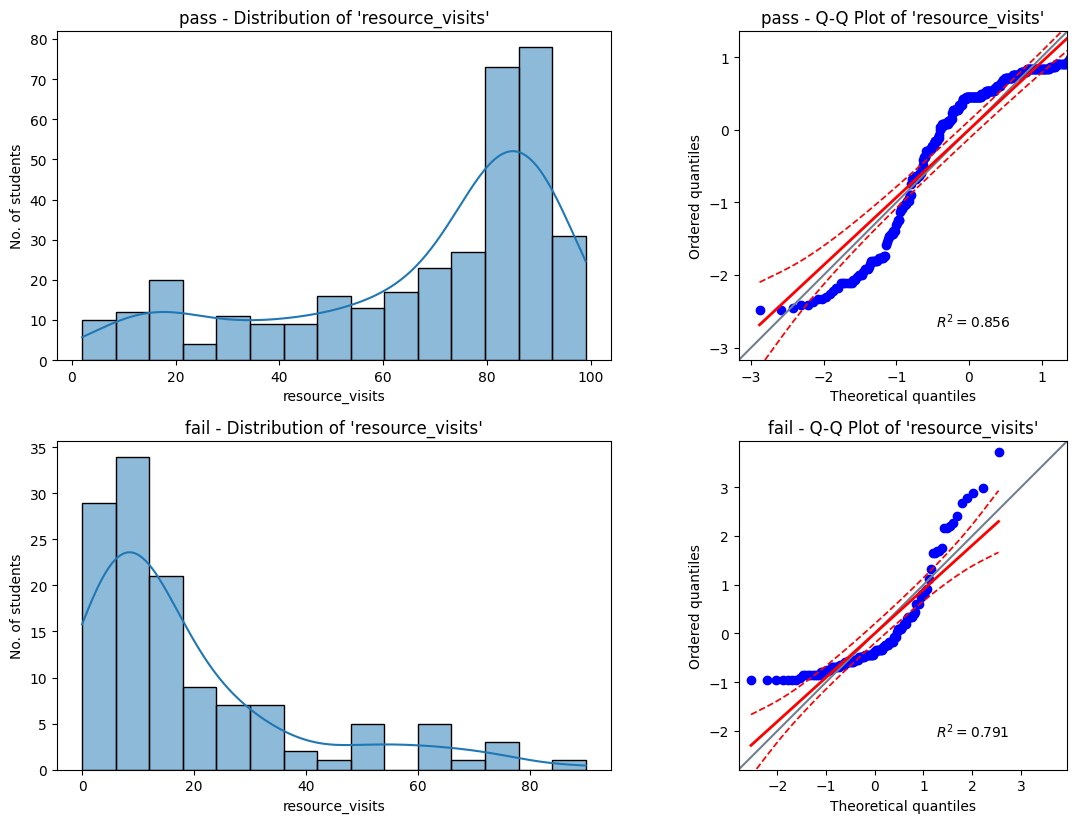

In [14]:
# Setup for plots
plt.figure(figsize=(12, 12))  # set figure size

for i, c in enumerate(['pass', 'fail']):   # iterate over 'pass' and 'fail' categories
    data = df[df['pass_fail_status'] == c]['resource_visits'] # filter data for current category
    
    # Histogram
    plt.subplot(3, 2, 2*i+1) # create subplot for histogram
    sns.histplot(data, kde=True, bins=15)  # include KDE for better visualization and set number of bins
    plt.title(f"{c} - Distribution of 'resource_visits'") # set title
    plt.xlabel("resource_visits") # set x-axis label
    plt.ylabel("No. of students") # set y-axis label
    
    # Q-Q Plot
    plt.subplot(3, 2, 2*i+2) # create subplot for Q-Q plot
    pg.qqplot(data, dist='norm')  # compare to normal distribution
    plt.title(f"{c} - Q-Q Plot of 'resource_visits'") # set title

plt.tight_layout() # adjust layout to prevent overlap
plt.show()

It can be seen for the histograms that the pass an fail groups have very different distributions of resource visits.  Pass group is more skewed to the right, i.e. it has a much greater population of students visited resources more frequently.

We will compute the mean and variance of the two distributions for comparison.

In [15]:
for c in ['pass', 'fail']: # iterate over 'pass' and 'fail' categories
    group_data = df[df['pass_fail_status'] == c]['resource_visits'] # filter data for current category
    mean_val = group_data.mean() # calculate mean
    var_val = group_data.var() # calculate variance
    
    print(f"{c.upper()} group:")
    print(f"  Mean      = {mean_val:.2f}")
    print(f"  Variance  = {var_val:.2f}\n")

PASS group:
  Mean      = 67.92
  Variance  = 704.61

FAIL group:
  Mean      = 18.42
  Variance  = 373.42



Similar to Hypothesis 1, the mean and variance results suggest that students who passed tend to visit resources more frequently on average, but also over a wider range.

For completeness, we proceed with the normality and hypothesis tests below.  We first use Shapiro_wilk to test for normality:

In [32]:
results = pg.normality(data=df, dv='resource_visits', group='pass_fail_status', method='shapiro') # Shapiro-Wilk test for normality (with significance level set to 0.05 as default)

print(results)

                         W          pval  normal
pass_fail_status                                
pass              0.852953  1.028691e-17   False
fail              0.790756  4.582891e-12   False


The data is not normally distributed, and so we will use a non-parametric test for the hypothesis testing.  Again we will use Kruskal-Wallis test.

In [34]:
# Kruskal-Wallis test - null hypothesis: the distributions of 'raised_hands' are the same across 'pass' and 'fail' groups
# significant level is set to 0.05 by default in Pingouin
result = pg.kruskal(data=df, dv='resource_visits', between='pass_fail_status')

print(result)

                   Source  ddof1          H         p-unc
Kruskal  pass_fail_status      1  187.82203  9.500554e-43


Since p-value (9.500554e-43) is lower than our significant level (assumed to be 0.05), there is enough evidence to reject the null hypothesis and conclude that the distributions of 'resource_visits' are different between the 'pass' and 'fail' groups.  This is consistent with our observations from the histogram plots above.

3. Students with a parent (or guardian) involved were more likely to pass.

We saw in the exploratory data analysis, [2_exploratory_analysis](https://github.com/8osco/academic_performance_analysis/blob/main/jupyter_notebooks/2_exploratory_analysis.ipynb), that parents are involved in all records, either father or mum.  We shall amend the hypothesis slightly to assess if mum vs father involvement is associated with pass/fail outcome.

We start by looking at the distributions of mum vs father involvement for the two groups.

In [ ]:
# Count parent involvement for the pass/fail groups separately
for status in ['pass', 'fail']:
    group_data = df[df['pass_fail_status'] == status]
    parent_counts = group_data['parent_involved'].value_counts()
    
    print(f"\n{status.upper()} group:")
    print(f"  Father count: {parent_counts.get('father', 0)}")
    print(f"  Mum count:    {parent_counts.get('mum', 0)}")


PASS group:
  Father count: 179
  Mum count:    174

FAIL group:
  Father count: 102
  Mum count:    23


It can be seen that pass group is indifferent to which parent was involved, whilst father accounts for more fails.

Chi-square test can be used to measure if there is a significance association between mum vs father involvement and pass/fail outcome.  We proceed the test with Pingouin.

In [ ]:
# Run chi-square test using Pingouin
# Null hypothesis: there is no association between parent involvement and pass/fail status
expected, observed, stats = pg.chi2_independence(data=df,x='parent_involved', y='pass_fail_status')

print(stats)

                 test    lambda       chi2  dof          pval    cramer  \
0             pearson  1.000000  35.096315  1.0  3.137941e-09  0.270967   
1        cressie-read  0.666667  35.793293  1.0  2.194019e-09  0.273645   
2      log-likelihood  0.000000  37.722867  1.0  8.154306e-10  0.280924   
3       freeman-tukey -0.500000  39.735068  1.0  2.908558e-10  0.288319   
4  mod-log-likelihood -1.000000  42.352371  1.0  7.622388e-11  0.297663   
5              neyman -2.000000  50.032018  1.0  1.512576e-12  0.323527   

      power  
0  0.999963  
1  0.999971  
2  0.999986  
3  0.999993  
4  0.999997  
5  1.000000  


0    3.137941e-09
Name: pval, dtype: float64

Locating just the result of the Pearson Chi-Square test:

In [31]:
stats.query("test == 'pearson'")['pval']

0    3.137941e-09
Name: pval, dtype: float64

The p-value is less than 0.05.  We therefore reject the null hypothesis and conclude that there is evidence that parent involvement type and pass/fail status are related.

4. Female students had a higher pass rate than male students.

Here, we will first examine the pass rates of the genders.

In [20]:
# Count total and passed students by gender
gender_group = df.groupby(['gender', 'pass_fail_status']).size().unstack(fill_value=0)

# Calculate pass rates
gender_group['pass_rate'] = gender_group['pass'] / (gender_group['pass'] + gender_group['fail'])

print(gender_group)

pass_fail_status  fail  pass  pass_rate
gender                                 
female              24   151   0.862857
male               101   202   0.666667


Female students have higher pass rates.

There are two statistical tests we can proceed with here:

a) Chi-square test, which tests whether pass/fail is independent of gender
b) Two-proportion Z-Test, which tests whether the pass rates of the two genders are significantly different

We proceed with the Chi-square test only here (due to time constraints):

In [35]:
# Run chi-square test using Pingouin
# Null hypothesis: there is no association between gender and pass/fail status
expected, observed, stats = pg.chi2_independence(data=df,x='gender', y='pass_fail_status')

print(stats)

                 test    lambda       chi2  dof          pval    cramer  \
0             pearson  1.000000  21.105314  1.0  4.347210e-06  0.210127   
1        cressie-read  0.666667  21.522552  1.0  3.496920e-06  0.212194   
2      log-likelihood  0.000000  22.575035  1.0  2.020937e-06  0.217320   
3       freeman-tukey -0.500000  23.587738  1.0  1.193456e-06  0.222141   
4  mod-log-likelihood -1.000000  24.830363  1.0  6.260355e-07  0.227917   
5              neyman -2.000000  28.190680  1.0  1.099326e-07  0.242850   

      power  
0  0.995782  
1  0.996311  
2  0.997376  
3  0.998115  
4  0.998749  
5  0.999595  


Locating just the result of the Pearson Chi-Square test:

In [36]:
stats.query("test == 'pearson'")['pval']

0    0.000004
Name: pval, dtype: float64

The p-value is less than 0.05.  We therefore reject the null hypothesis and conclude that there is evidence that gender and pass/fail status are related.

# Summary:

We have employed mean, variance, hypothesis testing, rate/probability above to help analysis distributions and differences between sub-groups.  These principles are foundational to data analysis, and help us gain insights into the patterns and relationships between variables.
